# Prostate cancer Prediction 
# Risk as the Response Variable

In [634]:
# Load necessary libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy import stats
from sklearn.model_selection import cross_val_score, KFold
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from scipy import stats


## Data Cleaning

In [635]:
data = pd.read_excel("PCA_Data.xlsx")

# Function to remove outliers
def remove_outliers(x):
    Q1 = np.percentile(x, 25)
    Q3 = np.percentile(x, 75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return np.where((x >= lower_bound) & (x <= upper_bound), x, np.nan)

# Remove outliers for each variable
for col in ['Exon9', 'Exon4a', 'Exon4b', 'baselinePSA']:
    data[col] = remove_outliers(data[col])

# Drop rows with missing values
data = data.dropna(subset=['Exon9', 'Exon4a', 'baselinePSA'])

## Data Visualization: Distribution

In [636]:
data['Gleason'].replace('N/A', 0, inplace=True)

# Convert Gleason Risk to binary: 1 for High, 0 for Low
data['GleasonRiskBinary'] = data['GleasonRiskCode'].astype('category')

data['GleasonCodes'] = np.where(data['Gleason'] == 0, 0, 
                                 np.where(data['Gleason'] == 6, 1, 
                                          np.where(data['Gleason'] >= 7, 2, 0)))

/var/folders/jj/v8sb93px4t91q34p4v5rc6780000gn/T/ipykernel_2072/2649967630.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data['Gleason'].replace('N/A', 0, inplace=True)


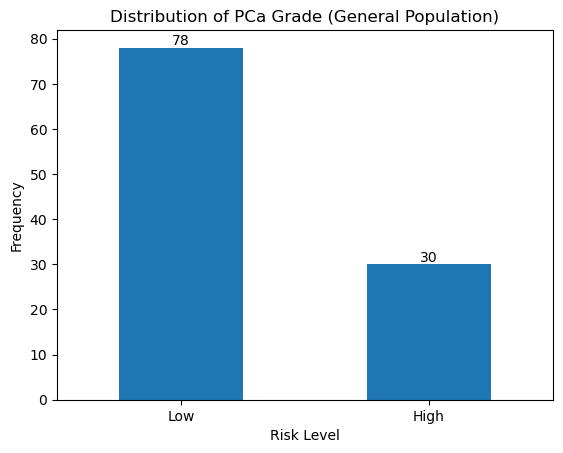

In [637]:
# Count the occurrences of each category
counts = data['Gleason Risk'].value_counts()

# Plot the bar graph
counts.plot(kind='bar')
plt.title('Distribution of PCa Grade (General Population)')
plt.xlabel('Risk Level')
plt.ylabel('Frequency')
plt.xticks(rotation=0)  # Keep labels horizontal for better readability

# Add numbers on top of the bars
for index, value in enumerate(counts):
    plt.text(index, value, str(value), ha='center', va='bottom', fontsize=10)

plt.show()


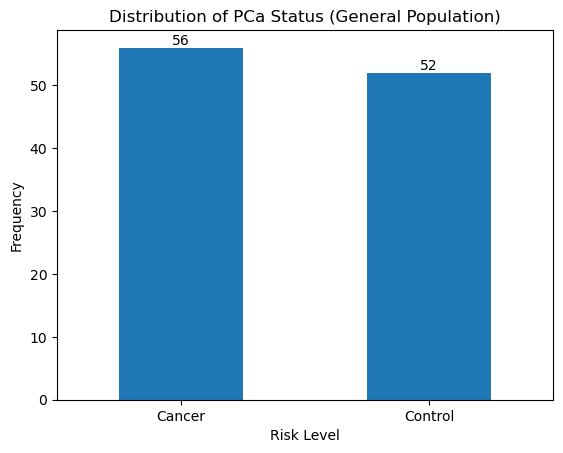

In [638]:
# Count the occurrences of each category
counts = data['Status'].value_counts()

# Plot the bar graph
counts.plot(kind='bar')
plt.title('Distribution of PCa Status (General Population)')
plt.xlabel('Risk Level')
plt.ylabel('Frequency')
plt.xticks(rotation=0)  # Keep labels horizontal for better readability

# Add numbers on top of the bars
for index, value in enumerate(counts):
    plt.text(index, value, str(value), ha='center', va='bottom', fontsize=10)

plt.show()

## Data Visualization: Boxplots

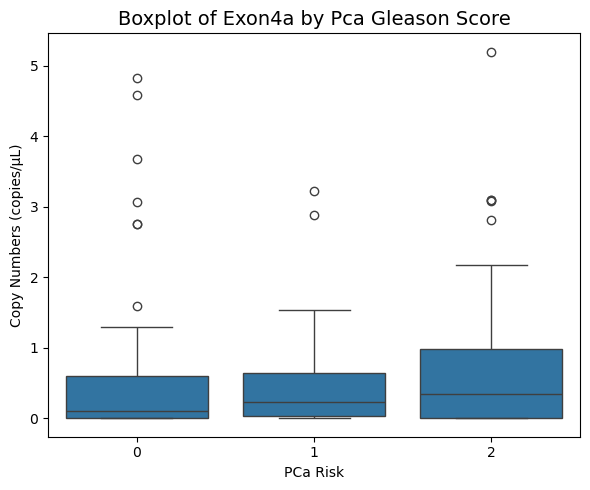

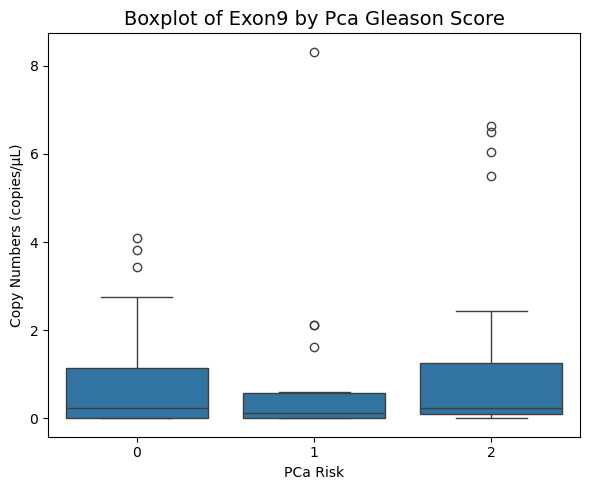

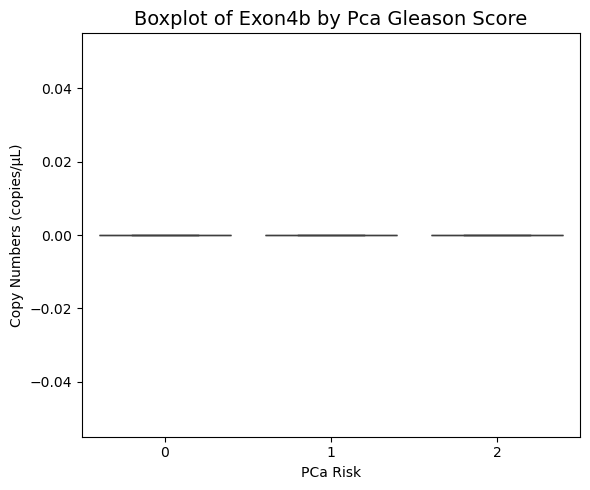

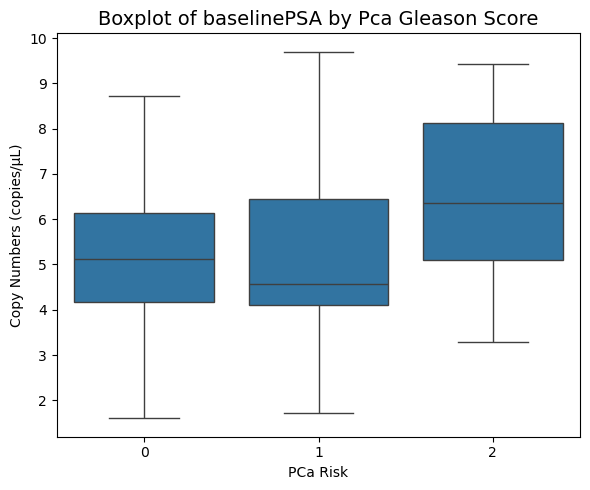

In [639]:
features = ['Exon4a', 'Exon9', 'Exon4b', 'baselinePSA'] 


for feature in features:
    plt.figure(figsize=(6, 5))

    # Plot boxplot for the current feature
    sns.boxplot(x='GleasonCodes', y=feature, data=data)
    
    # Customize the title and axis labels
    plt.title(f"Boxplot of {feature} by Pca Gleason Score", fontsize=14)
    plt.xlabel("PCa Risk")
    plt.ylabel("Copy Numbers (copies/µL)")
    
    # Display the plot
    plt.tight_layout()
    plt.show()

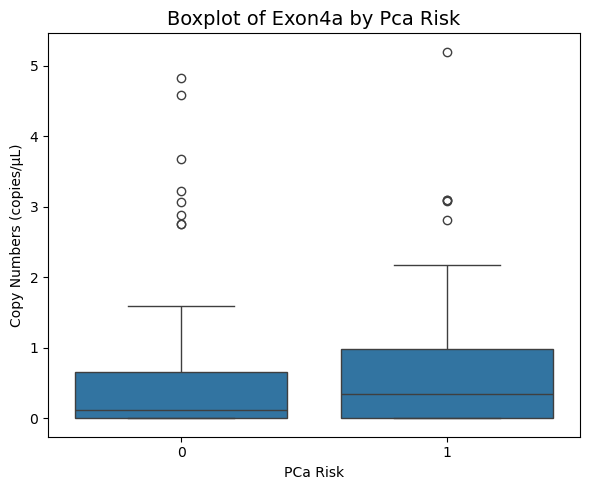

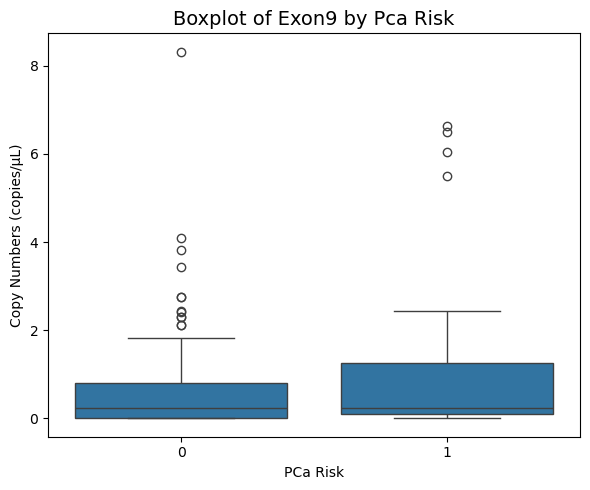

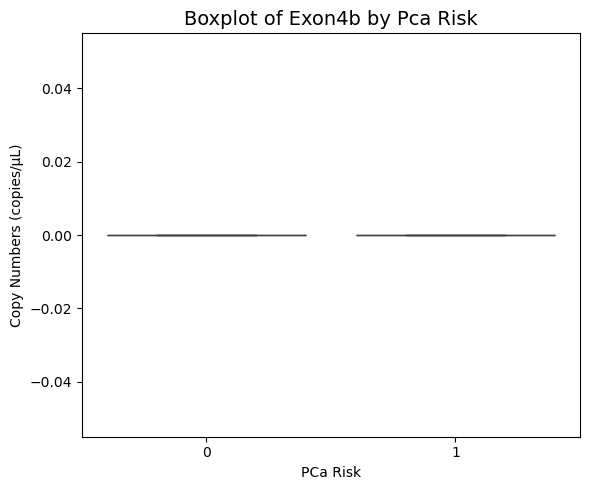

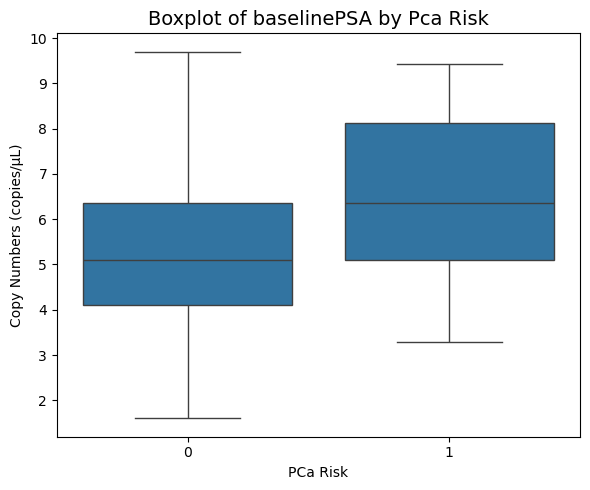

In [640]:

# Define the features
features = ['Exon4a', 'Exon9', 'Exon4b', 'baselinePSA']


# Create separate plots for each feature
for feature in features:
    plt.figure(figsize=(6, 5))

    # Plot boxplot for the current feature
    sns.boxplot(x='GleasonRiskBinary', y=feature, data=data)
    
    # Customize the title and axis labels
    plt.title(f"Boxplot of {feature} by Pca Risk", fontsize=14)
    plt.xlabel("PCa Risk")
    plt.ylabel("Copy Numbers (copies/µL)")
    
    # Display the plot
    plt.tight_layout()
    plt.show()

## Correlation Matrix

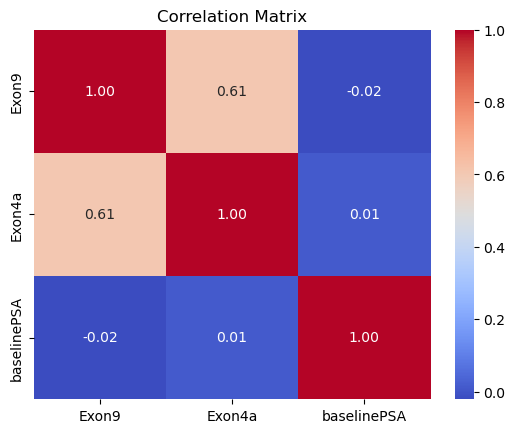

In [641]:
corr_matrix = data[['Exon9', 'Exon4a', 'baselinePSA']].corr()
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt='.2f')
plt.title('Correlation Matrix')
plt.show()

## Single Logistic Regression 

In [642]:
models = [
    ['Exon4a'],            
    ['Exon9'],
    ['baselinePSA']                    
]

for model in models:
    print(f"\nModel: {model}")
    
    X = data[model]
    y = data['GleasonRiskBinary']

    X = sm.add_constant(X)  # Adds a constant term to the predictor
    logit_model = sm.Logit(y, X)

    model_2 = logit_model.fit()
    print(model_2.summary())


Model: ['Exon4a']
Optimization terminated successfully.
         Current function value: 0.584099
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:      GleasonRiskBinary   No. Observations:                  108
Model:                          Logit   Df Residuals:                      106
Method:                           MLE   Df Model:                            1
Date:                Mon, 18 Nov 2024   Pseudo R-squ.:                 0.01141
Time:                        21:52:41   Log-Likelihood:                -63.083
converged:                       True   LL-Null:                       -63.811
Covariance Type:            nonrobust   LLR p-value:                    0.2275
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -1.1138      0.256     -4.347      0.000      -1.616      -0.612
Exon4a    

## Multiple Logisic Regression

In [643]:
models = [
    ['baselinePSA', 'Exon4a', 'Exon9'], 
    ['baselinePSA', 'Exon4a'],            
    ['baselinePSA', 'Exon9'],
    ['baselinePSA']                    
]

for model in models:
    print(f"\nModel: {model}")
    
    X = data[model]
    y = data['GleasonRiskBinary']

    X = sm.add_constant(X)  # Adds a constant term to the predictor
    logit_model = sm.Logit(y, X)

    model_2 = logit_model.fit()
    print(model_2.summary())

    


Model: ['baselinePSA', 'Exon4a', 'Exon9']
Optimization terminated successfully.
         Current function value: 0.528404
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:      GleasonRiskBinary   No. Observations:                  108
Model:                          Logit   Df Residuals:                      104
Method:                           MLE   Df Model:                            3
Date:                Mon, 18 Nov 2024   Pseudo R-squ.:                  0.1057
Time:                        21:52:41   Log-Likelihood:                -57.068
converged:                       True   LL-Null:                       -63.811
Covariance Type:            nonrobust   LLR p-value:                  0.003694
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const          -3.7405      0.894     -4.186      0.000      -5

## Train-Test Split 

### @ 0.5 threshold

### @80%, 20% train-test split

In [644]:

for model in models:
    print(f"\nMetrics for feature set: {model}")
    
    X = data[model]
    y = data['GleasonRiskBinary']

    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=66)

    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('logistic_regression', LogisticRegression())
    ])

    # Fit model
    pipeline.fit(X_train, y_train)

   # Get predicted probabilities
    y_pred_proba_train = pipeline.predict_proba(X_train)[:, 1]  # Probabilities for training set
    y_pred_proba = pipeline.predict_proba(X_test)[:, 1]          # Probabilities for test set

    # Apply threshold of 0.5 to get binary predictions
    y_pred_train = (y_pred_proba_train >= 0.5).astype(int)  # Convert to binary predictions for train set
    y_pred = (y_pred_proba >= 0.5).astype(int) 

    # Calculate metrics for the test set
    accuracy_test = metrics.accuracy_score(y_test, y_pred)
    recall_test = metrics.recall_score(y_test, y_pred)
    conf_matrix_test = confusion_matrix(y_test, y_pred)
    tn_test, fp_test, fn_test, tp_test = conf_matrix_test.ravel()
    specificity_test = tn_test / (tn_test + fp_test)

    # Print metrics for test set
    print("\nTest Set Metrics:")
    print(f"Accuracy: {accuracy_test:.3f}")
    print(f"Recall (Sensitivity): {recall_test:.3f}")
    print(f"Specificity: {specificity_test:.3f}")



Metrics for feature set: ['baselinePSA', 'Exon4a', 'Exon9']

Test Set Metrics:
Accuracy: 0.682
Recall (Sensitivity): 0.429
Specificity: 0.800

Metrics for feature set: ['baselinePSA', 'Exon4a']

Test Set Metrics:
Accuracy: 0.682
Recall (Sensitivity): 0.429
Specificity: 0.800

Metrics for feature set: ['baselinePSA', 'Exon9']

Test Set Metrics:
Accuracy: 0.773
Recall (Sensitivity): 0.429
Specificity: 0.933

Metrics for feature set: ['baselinePSA']

Test Set Metrics:
Accuracy: 0.773
Recall (Sensitivity): 0.429
Specificity: 0.933


### @Youden's index threshold

In [645]:

for model in models:
    print(f"\nMetrics for model: {model}")
    
    X = data[model]
    y = data['GleasonRiskBinary']

    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=66)

    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('logistic_regression', LogisticRegression())
    ])

    # Fit model
    pipeline.fit(X_train, y_train)

    # Get predicted probabilities
    y_pred_proba = pipeline.predict_proba(X_test)[:, 1]  # Probabilities for test set

    # Define thresholds
    thresholds = np.arange(0.0, 1.0, 0.1)
    best_youden_index = -1
    best_threshold = 0.5

    for threshold in thresholds:
        # Convert probabilities to binary predictions
        y_pred = (y_pred_proba >= threshold).astype(int)

        # Calculate confusion matrix
        conf_matrix = confusion_matrix(y_test, y_pred)

        # Check if the confusion matrix is valid for binary classification
        if conf_matrix.shape == (2, 2):
            tn, fp, fn, tp = conf_matrix.ravel()

            # Calculate sensitivity and specificity
            sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0
            specificity = tn / (tn + fp) if (tn + fp) > 0 else 0

            # Calculate Youden's Index
            youden_index = sensitivity + specificity - 1

            # Check if this is the best threshold
            if youden_index > best_youden_index:
                best_youden_index = youden_index
                best_threshold = threshold

    # Apply the best threshold for final predictions
    y_pred_final = (y_pred_proba >= best_threshold).astype(int)

    # Calculate final metrics using the best threshold
    accuracy_test = metrics.accuracy_score(y_test, y_pred_final)
    recall_test = metrics.recall_score(y_test, y_pred_final)
    conf_matrix_test = confusion_matrix(y_test, y_pred_final)

    # Check the shape of the final confusion matrix before unpacking
    if conf_matrix_test.shape == (2, 2):
        tn_test, fp_test, fn_test, tp_test = conf_matrix_test.ravel()
        specificity_test = tn_test / (tn_test + fp_test)

        # Print metrics for test set
        print("\nTest Set Metrics:")
        print(f"Best Threshold: {best_threshold:.2f}")
        print(f"Accuracy: {accuracy_test:.3f}")
        print(f"Recall (Sensitivity): {recall_test:.3f}")
        print(f"Specificity: {specificity_test:.3f}")
    else:
        print("\nTest Set Metrics:")
        print(f"Best Threshold: {best_threshold:.2f}")
        print(f"Accuracy: {accuracy_test:.3f}")
        print(f"Recall (Sensitivity): {recall_test:.3f}")
        print("Specificity: Not applicable (only one class present in predictions)")



Metrics for model: ['baselinePSA', 'Exon4a', 'Exon9']

Test Set Metrics:
Best Threshold: 0.30
Accuracy: 0.727
Recall (Sensitivity): 0.714
Specificity: 0.733

Metrics for model: ['baselinePSA', 'Exon4a']

Test Set Metrics:
Best Threshold: 0.30
Accuracy: 0.727
Recall (Sensitivity): 0.714
Specificity: 0.733

Metrics for model: ['baselinePSA', 'Exon9']

Test Set Metrics:
Best Threshold: 0.30
Accuracy: 0.773
Recall (Sensitivity): 0.857
Specificity: 0.733

Metrics for model: ['baselinePSA']

Test Set Metrics:
Best Threshold: 0.30
Accuracy: 0.682
Recall (Sensitivity): 0.714
Specificity: 0.667


##  10 fold Cross validation and AUC 


Metrics for feature set: ['baselinePSA', 'Exon4a', 'Exon9']
Fold 1: AUC = 0.893
Fold 2: AUC = 0.792
Fold 3: AUC = 0.917
Fold 4: AUC = 0.667
Fold 5: AUC = 0.679
Fold 6: AUC = 0.500
Fold 7: AUC = 1.000
Fold 8: AUC = 0.500
Fold 9: AUC = 0.429
Fold 10: AUC = 1.000
Overall AUC for model ['baselinePSA', 'Exon4a', 'Exon9']: 0.725


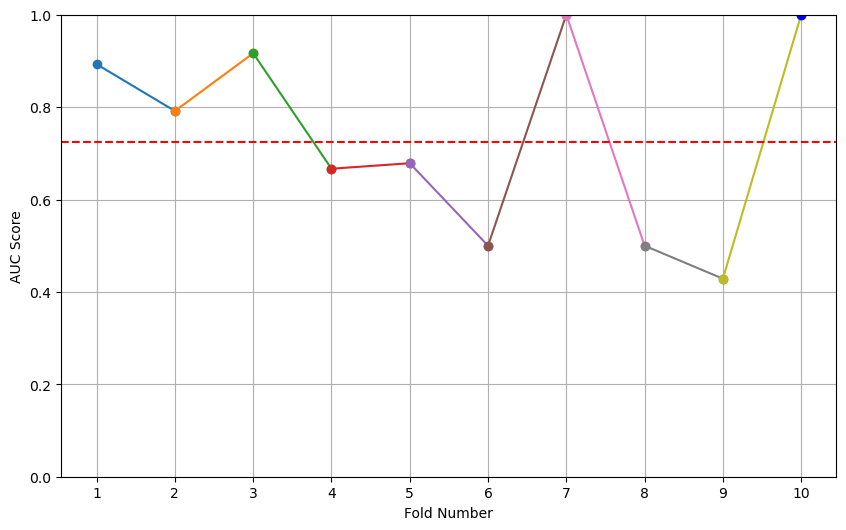


Metrics for feature set: ['baselinePSA', 'Exon4a']
Fold 1: AUC = 0.893
Fold 2: AUC = 0.667
Fold 3: AUC = 0.875
Fold 4: AUC = 0.667
Fold 5: AUC = 0.643
Fold 6: AUC = 0.500
Fold 7: AUC = 1.000
Fold 8: AUC = 0.556
Fold 9: AUC = 0.429
Fold 10: AUC = 1.000
Overall AUC for model ['baselinePSA', 'Exon4a']: 0.716


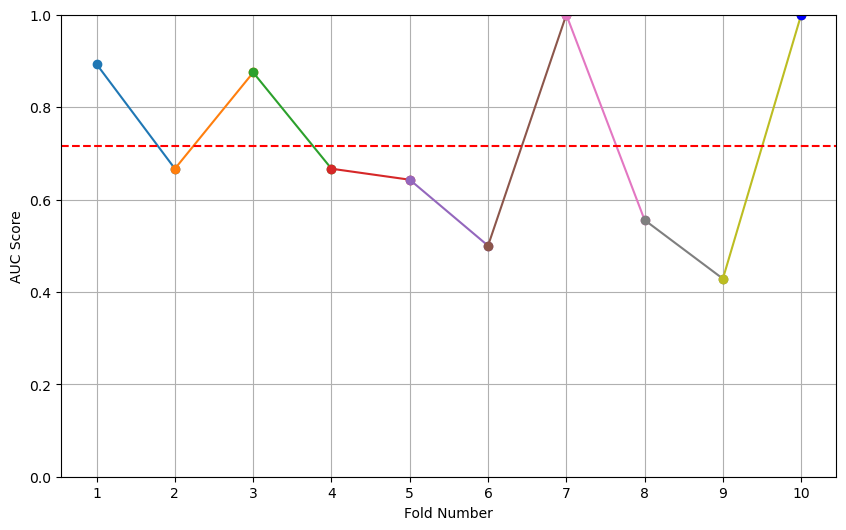


Metrics for feature set: ['baselinePSA', 'Exon9']
Fold 1: AUC = 0.893
Fold 2: AUC = 0.792
Fold 3: AUC = 0.958
Fold 4: AUC = 0.625
Fold 5: AUC = 0.714
Fold 6: AUC = 0.500
Fold 7: AUC = 0.944
Fold 8: AUC = 0.500
Fold 9: AUC = 0.381
Fold 10: AUC = 0.905
Overall AUC for model ['baselinePSA', 'Exon9']: 0.718


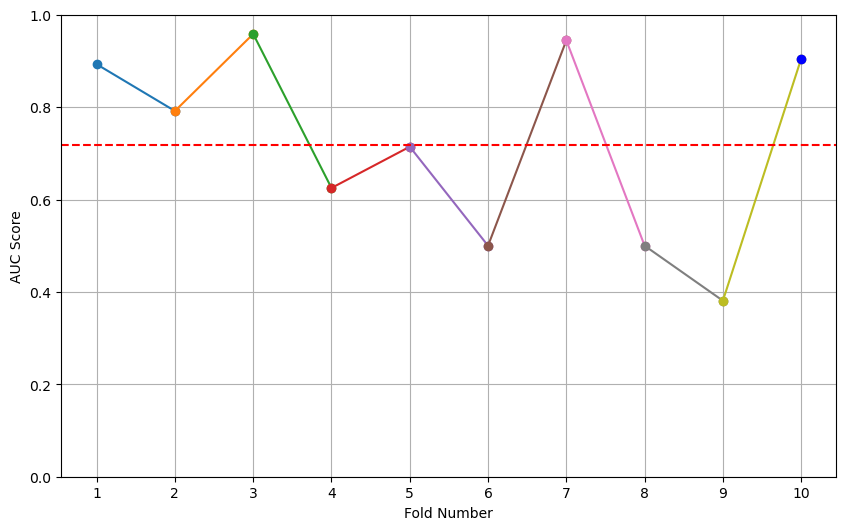


Metrics for feature set: ['baselinePSA']
Fold 1: AUC = 0.750
Fold 2: AUC = 0.750
Fold 3: AUC = 0.833
Fold 4: AUC = 0.750
Fold 5: AUC = 0.571
Fold 6: AUC = 0.500
Fold 7: AUC = 0.889
Fold 8: AUC = 0.611
Fold 9: AUC = 0.333
Fold 10: AUC = 0.857
Overall AUC for model ['baselinePSA']: 0.690


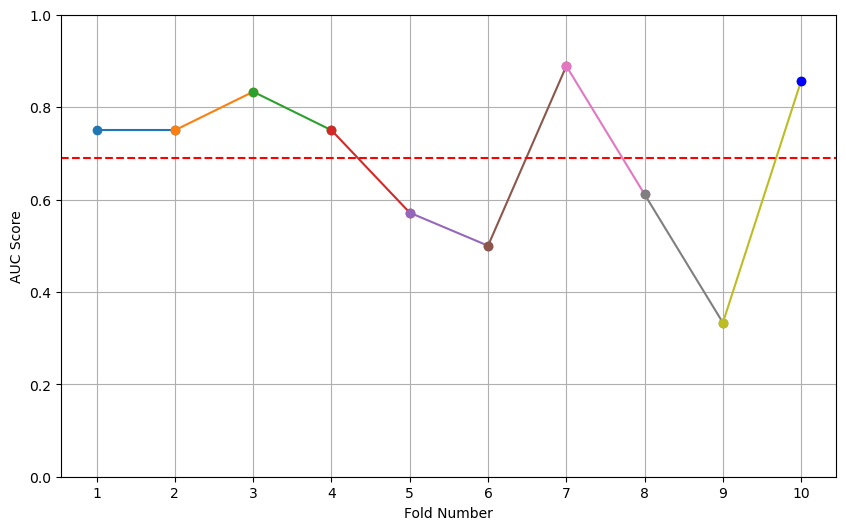

In [646]:
from sklearn import metrics
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
import numpy as np

# Loop through each model and perform 10-fold cross-validation
for model in models:
    print(f"\nMetrics for feature set: {model}")
    
    X = data[model]
    y = data['GleasonRiskBinary']

    # Initialize KFold
    kf = KFold(n_splits=10, shuffle=True, random_state=66)

    fold_auc_scores = []

    # Fit the model on the entire dataset once
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('logistic_regression', LogisticRegression())
    ])

    # Fit the model to the entire dataset
    pipeline.fit(X, y)

    # Get predicted probabilities for the entire dataset
    y_pred_proba = pipeline.predict_proba(X)[:, 1]

    # Calculate AUC for each fold
    for train_index, test_index in kf.split(X):
        # Use the indices to create test labels for AUC calculation
        y_test = y.iloc[test_index]
        y_pred_fold_proba = y_pred_proba[test_index]  # Get probabilities for the test fold

        # Check if both classes are present in the fold
        if len(y_test.unique()) > 1:
            # Calculate AUC for this fold
            fold_auc = metrics.roc_auc_score(y_test, y_pred_fold_proba)
            fold_auc_scores.append(fold_auc)
        else:
            print("Skipping fold due to single class in y_test")

    # Print AUC for each fold
    for i, auc in enumerate(fold_auc_scores):
        print(f"Fold {i + 1}: AUC = {auc:.3f}")

    # Calculate overall AUC using roc_auc_score on the entire predictions
    overall_auc = metrics.roc_auc_score(y, y_pred_proba)
    print(f"Overall AUC for model {model}: {overall_auc:.3f}")

    # Plot AUC for this model with individual segments
    plt.figure(figsize=(10, 6))
    for i in range(len(fold_auc_scores) - 1):
        plt.plot([i + 1, i + 2], [fold_auc_scores[i], fold_auc_scores[i + 1]], marker='o', label=f'Model: {model}' if i == 0 else "")

    # Add last point
    plt.plot([10], [fold_auc_scores[-1]], marker='o', color='b')  

    plt.axhline(y=overall_auc, color='r', linestyle='--', label=f'Overall AUC = {overall_auc:.3f}')

    plt.xlabel('Fold Number')
    plt.ylabel('AUC Score')
    plt.ylim(0, 1)
    plt.xticks(np.arange(1, 11))
    plt.grid()
    plt.show()


## Likelihood Ratio Test 

In [647]:

# Custom function for chi-square probability
stats.chisqprob = lambda chisq, df: stats.chi2.sf(chisq, df)

# Define function to perform likelihood ratio test
def likelihood_ratio_test(llmin, llmax):
    lr_stat = 2 * (llmax - llmin)
    p_value = stats.chisqprob(lr_stat, 1)  # llmax has 1 dof more than llmin
    return lr_stat, p_value  # Results of likelihood ratio test

# Response variable
y = data['GleasonRiskBinary']

# Define model pairs for comparison
model_pairs = [
    (['baselinePSA', 'Exon4a', 'Exon9'], ['baselinePSA', 'Exon4a']),
    (['baselinePSA', 'Exon4a', 'Exon9'], ['baselinePSA', 'Exon9']),
    (['baselinePSA', 'Exon4a'], ['baselinePSA']),
    (['baselinePSA', 'Exon9'], ['baselinePSA'])
]

# Loop through each model pair
for full_features, reduced_features in model_pairs:
    print(f"\nTesting model: {full_features} vs {reduced_features}")

    # Fit the full model
    X_full = data[full_features]
    X_full = sm.add_constant(X_full)  # Adding intercept
    full_model = sm.Logit(y, X_full).fit(disp=0)  # disp=0 to suppress output

    # Fit the reduced model
    X_reduced = data[reduced_features]
    X_reduced = sm.add_constant(X_reduced)  # Adding intercept
    reduced_model = sm.Logit(y, X_reduced).fit(disp=0)  # disp=0 to suppress output

    # Get log-likelihood values
    llmax = full_model.llf  # Log-likelihood of the full model
    llmin = reduced_model.llf  # Log-likelihood of the reduced model

    # Perform the likelihood ratio test
    lr_stat, p_value = likelihood_ratio_test(llmin, llmax)

    # Print results
    print(f"Likelihood Ratio Statistic: {lr_stat:.4f}")
    print(f"P-value: {p_value:.4f}")



Testing model: ['baselinePSA', 'Exon4a', 'Exon9'] vs ['baselinePSA', 'Exon4a']
Likelihood Ratio Statistic: 1.1686
P-value: 0.2797

Testing model: ['baselinePSA', 'Exon4a', 'Exon9'] vs ['baselinePSA', 'Exon9']
Likelihood Ratio Statistic: 0.1593
P-value: 0.6898

Testing model: ['baselinePSA', 'Exon4a'] vs ['baselinePSA']
Likelihood Ratio Statistic: 1.6672
P-value: 0.1966

Testing model: ['baselinePSA', 'Exon9'] vs ['baselinePSA']
Likelihood Ratio Statistic: 2.6765
P-value: 0.1018


# Prostate cancer Prediction 
# Status as the Response Variable

In [648]:
# Convert Statuscode to categorical
data['Statuscode'] = data['Statuscode'].astype('category')


# Convert Statuscode to numeric
data['Statuscode'] = pd.to_numeric(data['Statuscode'], errors='coerce')

# Check for NaN values
print(data['Statuscode'].isnull().sum())  # Handle NaNs if any

# Drop NaN rows if necessary
data = data.dropna(subset=['Statuscode'])

0


## Data Visualization: Boxplots


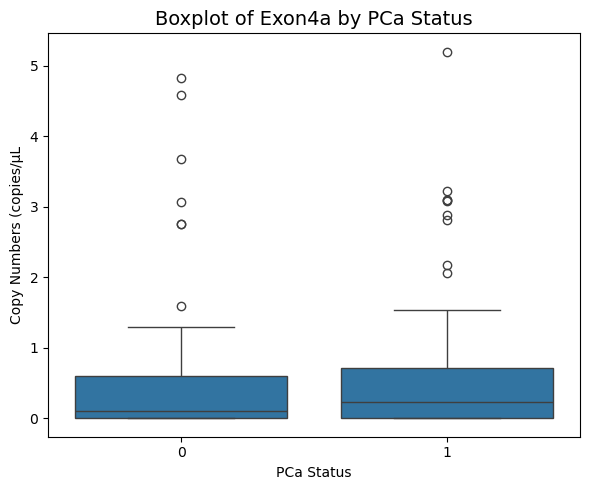

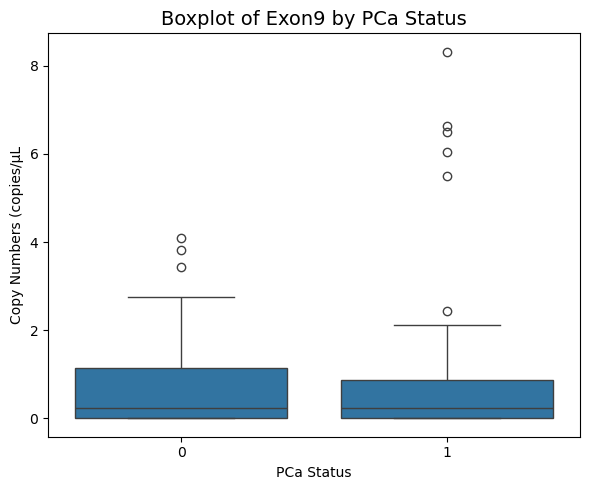

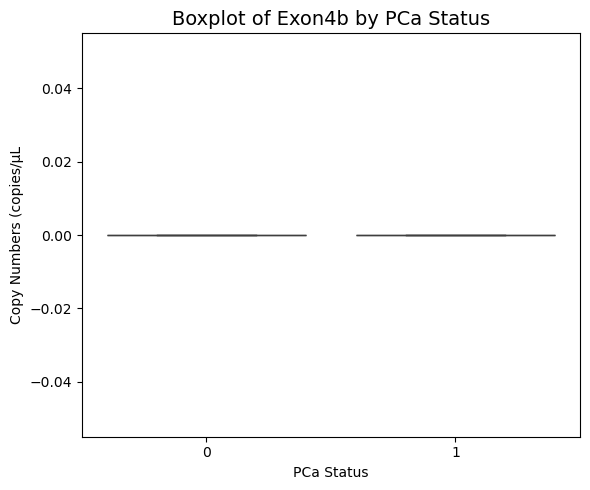

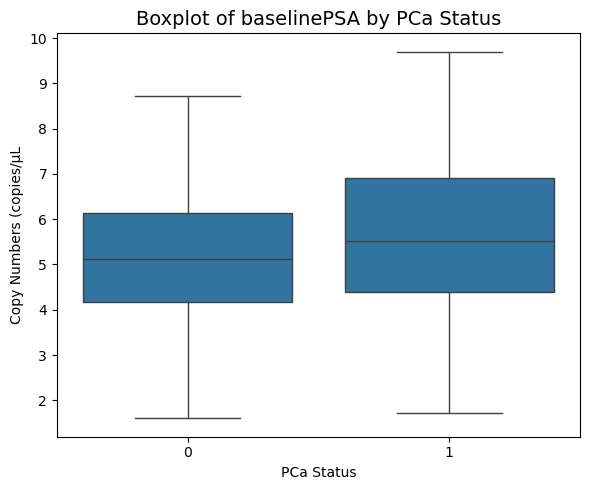

In [649]:
# Define the features
features = ['Exon4a', 'Exon9', 'Exon4b', 'baselinePSA']

# Create separate plots for each feature
for feature in features:
    plt.figure(figsize=(6, 5))
    
    # Plot boxplot for the current feature
    sns.boxplot(x='Statuscode', y=feature, data=data)
    
    # Customize the title and axis labels
    plt.title(f"Boxplot of {feature} by PCa Status", fontsize=14)
    plt.xlabel("PCa Status")
    plt.ylabel('Copy Numbers (copies/µL')
    
    # Display the plot
    plt.tight_layout()
    plt.show()


## Single Logistic Regression

In [650]:
models = [
    ['Exon4a'],            
    ['Exon9'],
    ['baselinePSA']                    
]

for model in models:
    print(f"\nModel: {model}")
    
    X = data[model]
    y = data['Statuscode']

    X = sm.add_constant(X)  # Adds a constant term to the predictor
    logit_model = sm.Logit(y, X)

    model_2 = logit_model.fit()
    print(model_2.summary())


Model: ['Exon4a']
Optimization terminated successfully.
         Current function value: 0.691486
         Iterations 4
                           Logit Regression Results                           
Dep. Variable:             Statuscode   No. Observations:                  108
Model:                          Logit   Df Residuals:                      106
Method:                           MLE   Df Model:                            1
Date:                Mon, 18 Nov 2024   Pseudo R-squ.:                0.001409
Time:                        21:52:42   Log-Likelihood:                -74.680
converged:                       True   LL-Null:                       -74.786
Covariance Type:            nonrobust   LLR p-value:                    0.6462
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0213      0.224      0.095      0.924      -0.418       0.461
Exon4a    

## Multiple Logistic Regression

In [651]:
models = [
    ['baselinePSA', 'Exon4a', 'Exon9'], 
    ['baselinePSA', 'Exon4a'],            
    ['baselinePSA', 'Exon9'],
    ['baselinePSA']                    
]

for model in models:
    print(f"\nModel: {model}")
    
    X = data[model]
    y = data['Statuscode']

    X = sm.add_constant(X)  # Adds a constant term to the predictor
    logit_model = sm.Logit(y, X)

    model_2 = logit_model.fit()
    print(model_2.summary())


Model: ['baselinePSA', 'Exon4a', 'Exon9']
Optimization terminated successfully.
         Current function value: 0.669525
         Iterations 4
                           Logit Regression Results                           
Dep. Variable:             Statuscode   No. Observations:                  108
Model:                          Logit   Df Residuals:                      104
Method:                           MLE   Df Model:                            3
Date:                Mon, 18 Nov 2024   Pseudo R-squ.:                 0.03312
Time:                        21:52:42   Log-Likelihood:                -72.309
converged:                       True   LL-Null:                       -74.786
Covariance Type:            nonrobust   LLR p-value:                    0.1752
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const          -1.3428      0.694     -1.935      0.053      -2

## Train Test Split

### @Youden's index 0.5 threshold

In [652]:

for model in models:
    print(f"\nMetrics for model: {model}")
    
    X = data[model]
    y = data['Statuscode']

    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=66)

    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('logistic_regression', LogisticRegression())
    ])

    # Fit model
    pipeline.fit(X_train, y_train)

    # Get predicted probabilities
    y_pred_proba = pipeline.predict_proba(X_test)[:, 1]  # Probabilities for test set

    # Define thresholds
    thresholds = np.arange(0.0, 1.0, 0.1)
    best_youden_index = -1
    best_threshold = 0.5

    for threshold in thresholds:
        # Convert probabilities to binary predictions
        y_pred = (y_pred_proba >= threshold).astype(int)

        # Calculate confusion matrix
        conf_matrix = confusion_matrix(y_test, y_pred)

        # Check if the confusion matrix is valid for binary classification
        if conf_matrix.shape == (2, 2):
            tn, fp, fn, tp = conf_matrix.ravel()

            # Calculate sensitivity and specificity
            sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0
            specificity = tn / (tn + fp) if (tn + fp) > 0 else 0

            # Calculate Youden's Index
            youden_index = sensitivity + specificity - 1

            # Check if this is the best threshold
            if youden_index > best_youden_index:
                best_youden_index = youden_index
                best_threshold = threshold

    # Apply the best threshold for final predictions
    y_pred_final = (y_pred_proba >= best_threshold).astype(int)

    # Calculate final metrics using the best threshold
    accuracy_test = metrics.accuracy_score(y_test, y_pred_final)
    recall_test = metrics.recall_score(y_test, y_pred_final)
    conf_matrix_test = confusion_matrix(y_test, y_pred_final)

    # Check the shape of the final confusion matrix before unpacking
    if conf_matrix_test.shape == (2, 2):
        tn_test, fp_test, fn_test, tp_test = conf_matrix_test.ravel()
        specificity_test = tn_test / (tn_test + fp_test)

        # Print metrics for test set
        print("\nTest Set Metrics:")
        print(f"Best Threshold: {best_threshold:.2f}")
        print(f"Accuracy: {accuracy_test:.3f}")
        print(f"Recall (Sensitivity): {recall_test:.3f}")
        print(f"Specificity: {specificity_test:.3f}")
    else:
        print("\nTest Set Metrics:")
        print(f"Best Threshold: {best_threshold:.2f}")
        print(f"Accuracy: {accuracy_test:.3f}")
        print(f"Recall (Sensitivity): {recall_test:.3f}")
        print("Specificity: Not applicable (only one class present in predictions)")



Metrics for model: ['baselinePSA', 'Exon4a', 'Exon9']

Test Set Metrics:
Best Threshold: 0.50
Accuracy: 0.636
Recall (Sensitivity): 0.727
Specificity: 0.545

Metrics for model: ['baselinePSA', 'Exon4a']

Test Set Metrics:
Best Threshold: 0.50
Accuracy: 0.682
Recall (Sensitivity): 0.818
Specificity: 0.545

Metrics for model: ['baselinePSA', 'Exon9']

Test Set Metrics:
Best Threshold: 0.60
Accuracy: 0.727
Recall (Sensitivity): 0.455
Specificity: 1.000

Metrics for model: ['baselinePSA']

Test Set Metrics:
Best Threshold: 0.50
Accuracy: 0.636
Recall (Sensitivity): 0.818
Specificity: 0.455


## 10 fold Cross Validation


Metrics for feature set: ['baselinePSA', 'Exon4a', 'Exon9']
Fold 1: AUC = 0.821
Fold 2: AUC = 0.929
Fold 3: AUC = 0.667
Fold 4: AUC = 0.500
Fold 5: AUC = 0.643
Fold 6: AUC = 0.633
Fold 7: AUC = 0.833
Fold 8: AUC = 0.125
Fold 9: AUC = 0.417
Fold 10: AUC = 0.760
Overall AUC for model ['baselinePSA', 'Exon4a', 'Exon9']: 0.614


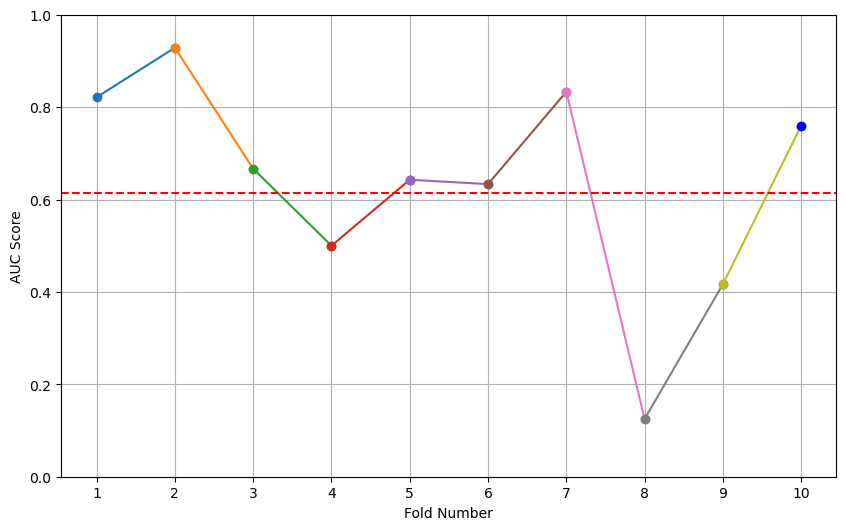


Metrics for feature set: ['baselinePSA', 'Exon4a']
Fold 1: AUC = 0.821
Fold 2: AUC = 0.857
Fold 3: AUC = 0.700
Fold 4: AUC = 0.533
Fold 5: AUC = 0.500
Fold 6: AUC = 0.633
Fold 7: AUC = 0.900
Fold 8: AUC = 0.167
Fold 9: AUC = 0.500
Fold 10: AUC = 0.800
Overall AUC for model ['baselinePSA', 'Exon4a']: 0.613


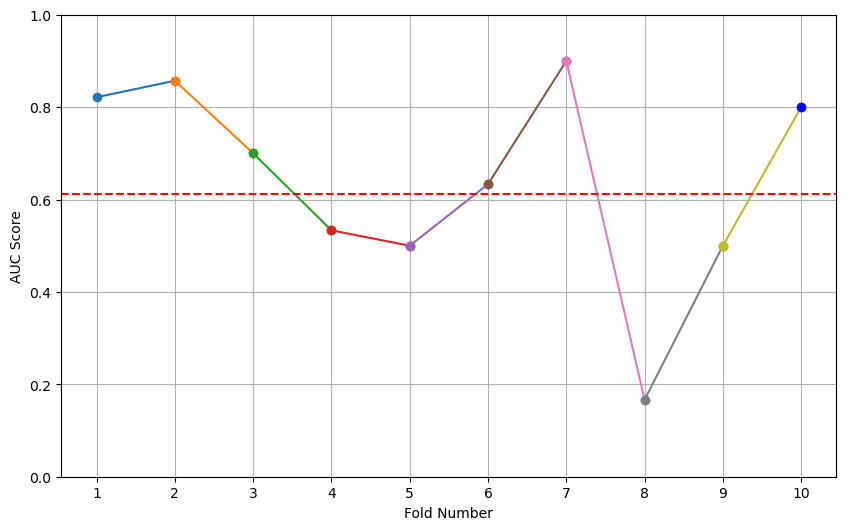


Metrics for feature set: ['baselinePSA', 'Exon9']
Fold 1: AUC = 0.839
Fold 2: AUC = 0.929
Fold 3: AUC = 0.667
Fold 4: AUC = 0.467
Fold 5: AUC = 0.643
Fold 6: AUC = 0.633
Fold 7: AUC = 0.867
Fold 8: AUC = 0.125
Fold 9: AUC = 0.417
Fold 10: AUC = 0.760
Overall AUC for model ['baselinePSA', 'Exon9']: 0.617


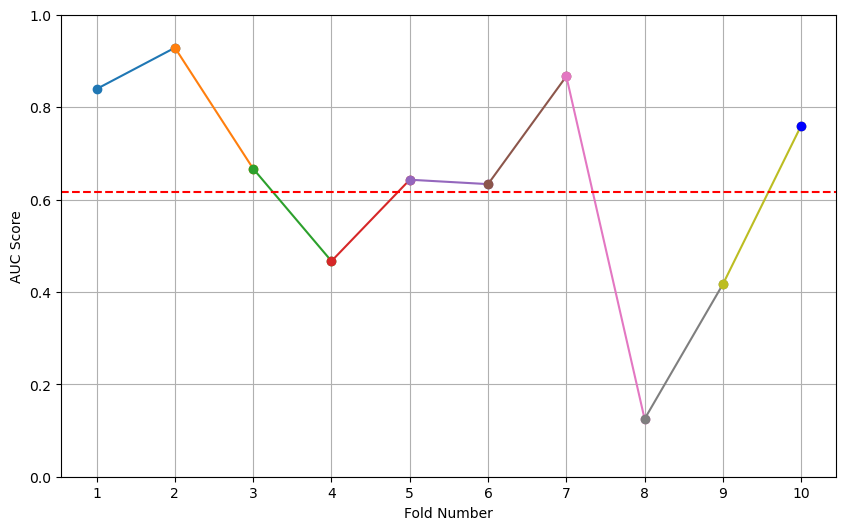


Metrics for feature set: ['baselinePSA']
Fold 1: AUC = 0.768
Fold 2: AUC = 0.893
Fold 3: AUC = 0.667
Fold 4: AUC = 0.550
Fold 5: AUC = 0.393
Fold 6: AUC = 0.667
Fold 7: AUC = 0.867
Fold 8: AUC = 0.167
Fold 9: AUC = 0.458
Fold 10: AUC = 0.720
Overall AUC for model ['baselinePSA']: 0.600


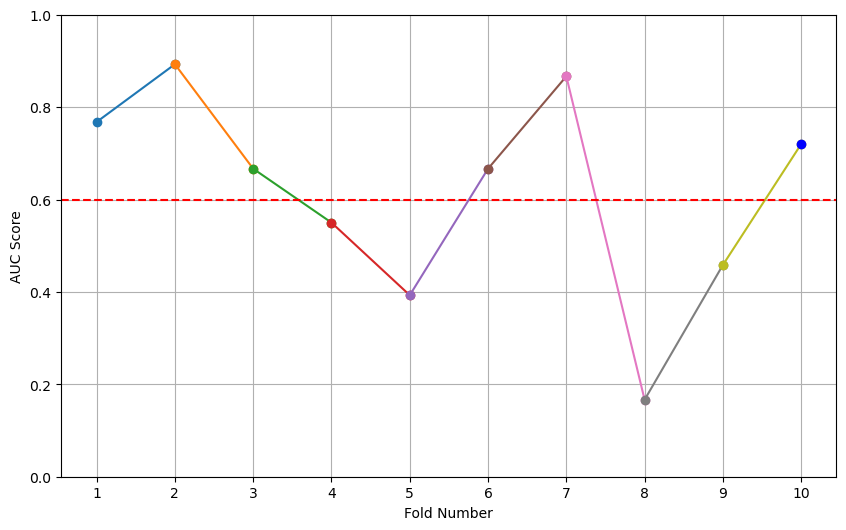

In [653]:
from sklearn import metrics
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
import numpy as np

# Loop through each model and perform 10-fold cross-validation
for model in models:
    print(f"\nMetrics for feature set: {model}")
    
    X = data[model]
    y = data['Statuscode']

    # Initialize KFold
    kf = KFold(n_splits=10, shuffle=True, random_state=66)

    fold_auc_scores = []

    # Fit the model on the entire dataset once
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('logistic_regression', LogisticRegression())
    ])

    # Fit the model to the entire dataset
    pipeline.fit(X, y)

    # Get predicted probabilities for the entire dataset
    y_pred_proba = pipeline.predict_proba(X)[:, 1]

    # Calculate AUC for each fold
    for train_index, test_index in kf.split(X):
        # Use the indices to create test labels for AUC calculation
        y_test = y.iloc[test_index]
        y_pred_fold_proba = y_pred_proba[test_index]  # Get probabilities for the test fold

        # Check if both classes are present in the fold
        if len(y_test.unique()) > 1:
            # Calculate AUC for this fold
            fold_auc = metrics.roc_auc_score(y_test, y_pred_fold_proba)
            fold_auc_scores.append(fold_auc)
        else:
            print("Skipping fold due to single class in y_test")

    # Print AUC for each fold
    for i, auc in enumerate(fold_auc_scores):
        print(f"Fold {i + 1}: AUC = {auc:.3f}")

    # Calculate overall AUC using roc_auc_score on the entire predictions
    overall_auc = metrics.roc_auc_score(y, y_pred_proba)
    print(f"Overall AUC for model {model}: {overall_auc:.3f}")

    # Plot AUC for this model with individual segments
    plt.figure(figsize=(10, 6))
    for i in range(len(fold_auc_scores) - 1):
        plt.plot([i + 1, i + 2], [fold_auc_scores[i], fold_auc_scores[i + 1]], marker='o', label=f'Model: {model}' if i == 0 else "")

    # Add last point
    plt.plot([10], [fold_auc_scores[-1]], marker='o', color='b')  

    plt.axhline(y=overall_auc, color='r', linestyle='--', label=f'Overall AUC = {overall_auc:.3f}')

    plt.xlabel('Fold Number')
    plt.ylabel('AUC Score')
    plt.ylim(0, 1)
    plt.xticks(np.arange(1, 11))
    plt.grid()
    plt.show()


## Likelihood Ratio Test

In [654]:

# Custom function for chi-square probability
stats.chisqprob = lambda chisq, df: stats.chi2.sf(chisq, df)

# Define function to perform likelihood ratio test
def likelihood_ratio_test(llmin, llmax):
    lr_stat = 2 * (llmax - llmin)
    p_value = stats.chisqprob(lr_stat, 1)  # llmax has 1 dof more than llmin
    return lr_stat, p_value  # Results of likelihood ratio test

# Response variable
y = data['Statuscode']

# Define model pairs for comparison
model_pairs = [
    (['baselinePSA', 'Exon4a', 'Exon9'], ['baselinePSA', 'Exon4a']),
    (['baselinePSA', 'Exon4a', 'Exon9'], ['baselinePSA', 'Exon9']),
    (['baselinePSA', 'Exon4a'], ['baselinePSA']),
    (['baselinePSA', 'Exon9'], ['baselinePSA'])
]

# Loop through each model pair
for full_features, reduced_features in model_pairs:
    print(f"\nTesting model: {full_features} vs {reduced_features}")

    # Fit the full model
    X_full = data[full_features]
    X_full = sm.add_constant(X_full)  # Adding intercept
    full_model = sm.Logit(y, X_full).fit(disp=0)  # disp=0 to suppress output

    # Fit the reduced model
    X_reduced = data[reduced_features]
    X_reduced = sm.add_constant(X_reduced)  # Adding intercept
    reduced_model = sm.Logit(y, X_reduced).fit(disp=0)  # disp=0 to suppress output

    # Get log-likelihood values
    llmax = full_model.llf  # Log-likelihood of the full model
    llmin = reduced_model.llf  # Log-likelihood of the reduced model

    # Perform the likelihood ratio test
    lr_stat, p_value = likelihood_ratio_test(llmin, llmax)

    # Print results
    print(f"Likelihood Ratio Statistic: {lr_stat:.4f}")
    print(f"P-value: {p_value:.4f}")



Testing model: ['baselinePSA', 'Exon4a', 'Exon9'] vs ['baselinePSA', 'Exon4a']
Likelihood Ratio Statistic: 0.4849
P-value: 0.4862

Testing model: ['baselinePSA', 'Exon4a', 'Exon9'] vs ['baselinePSA', 'Exon9']
Likelihood Ratio Statistic: 0.0060
P-value: 0.9383

Testing model: ['baselinePSA', 'Exon4a'] vs ['baselinePSA']
Likelihood Ratio Statistic: 0.1909
P-value: 0.6622

Testing model: ['baselinePSA', 'Exon9'] vs ['baselinePSA']
Likelihood Ratio Statistic: 0.6699
P-value: 0.4131


# Prostate cancer Prediction 
# Risk as the Response Variable
# Men of African Ancenstry

In [655]:
data = pd.read_excel("PCA_Data.xlsx")
data = data[data['RACE'] == 'Black']

# Function to remove outliers
def remove_outliers(x):
    Q1 = np.percentile(x, 25)
    Q3 = np.percentile(x, 75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return np.where((x >= lower_bound) & (x <= upper_bound), x, np.nan)

# Remove outliers for each variable
for col in ['Exon9', 'Exon4a', 'Exon4b', 'baselinePSA']:
    data[col] = remove_outliers(data[col])

# Drop rows with missing values
data = data.dropna(subset=['Exon9', 'Exon4a', 'baselinePSA'])

## Data Distribution

In [656]:
data['Gleason'].replace('N/A', 0, inplace=True)

# Convert Gleason Risk to binary: 1 for High, 0 for Low
data['GleasonRiskBinary'] = data['GleasonRiskCode'].astype('category')

data['GleasonCodes'] = np.where(data['Gleason'] == 0, 0, 
                                 np.where(data['Gleason'] == 6, 1, 
                                          np.where(data['Gleason'] >= 7, 2, 0)))

/var/folders/jj/v8sb93px4t91q34p4v5rc6780000gn/T/ipykernel_2072/2649967630.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data['Gleason'].replace('N/A', 0, inplace=True)


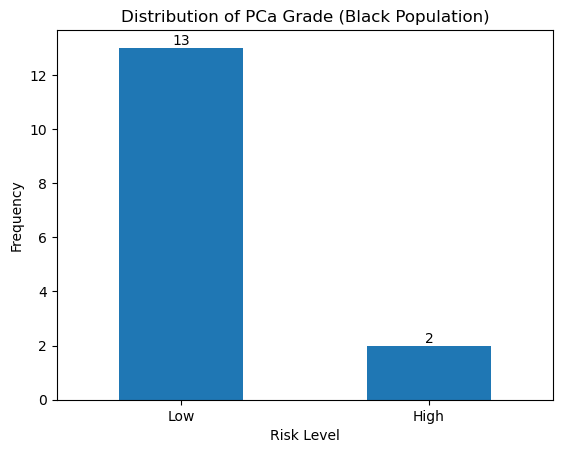

In [657]:
# Count the occurrences of each category
counts = data['Gleason Risk'].value_counts()

# Plot the bar graph
counts.plot(kind='bar')
plt.title('Distribution of PCa Grade (Black Population)')
plt.xlabel('Risk Level')
plt.ylabel('Frequency')
plt.xticks(rotation=0)  # Keep labels horizontal for better readability

# Add numbers on top of the bars
for index, value in enumerate(counts):
    plt.text(index, value, str(value), ha='center', va='bottom', fontsize=10)

plt.show()

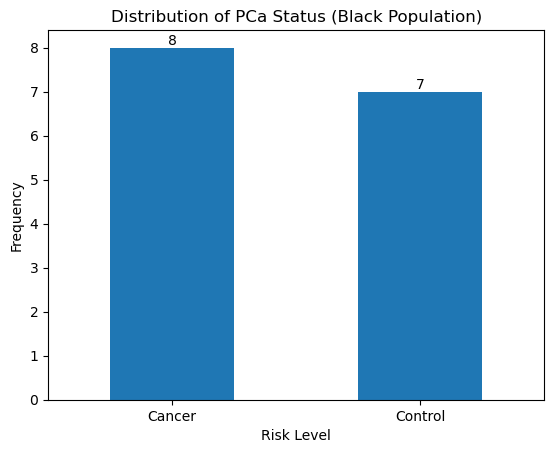

In [658]:
# Count the occurrences of each category
counts = data['Status'].value_counts()

# Plot the bar graph
counts.plot(kind='bar')
plt.title('Distribution of PCa Status (Black Population)')
plt.xlabel('Risk Level')
plt.ylabel('Frequency')
plt.xticks(rotation=0)  # Keep labels horizontal for better readability

# Add numbers on top of the bars
for index, value in enumerate(counts):
    plt.text(index, value, str(value), ha='center', va='bottom', fontsize=10)

plt.show()

## Data Visualizations and Boxplots

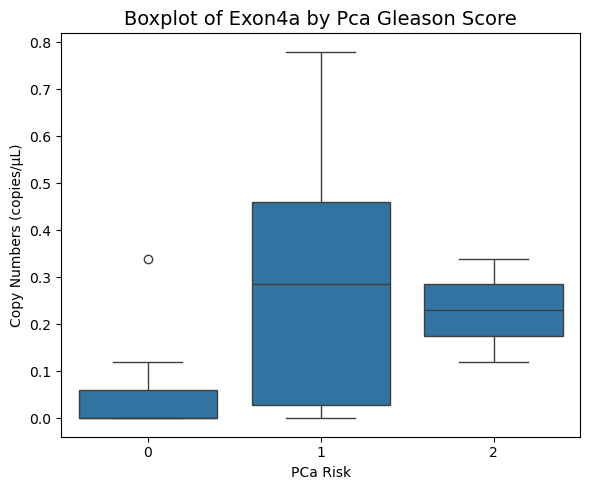

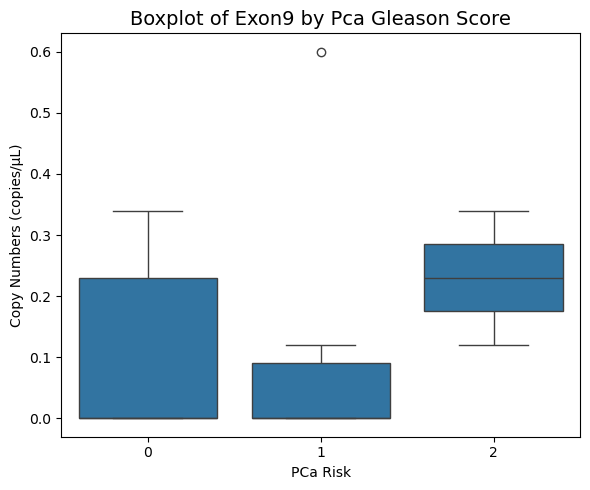

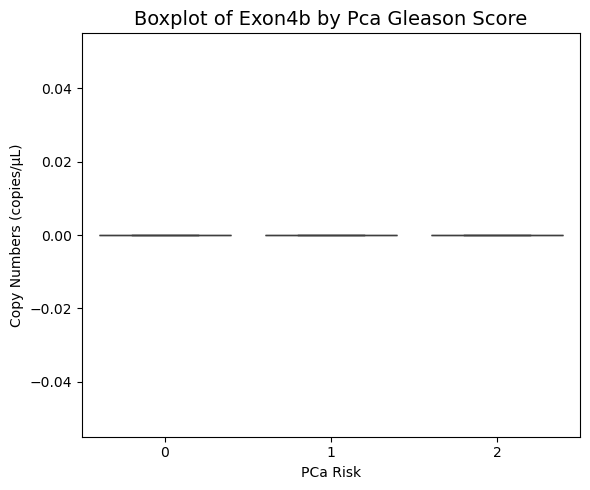

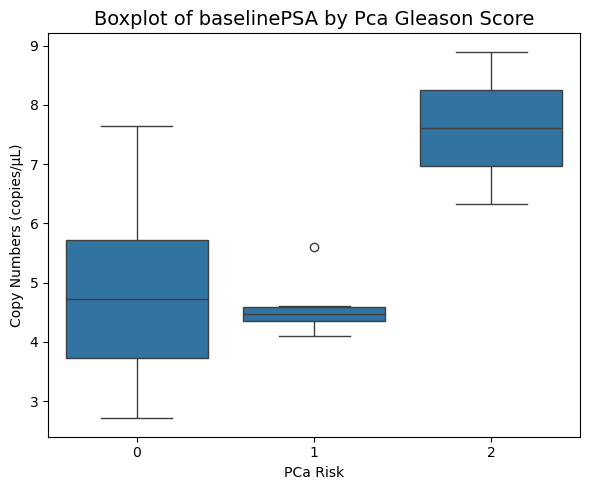

In [659]:
features = ['Exon4a', 'Exon9', 'Exon4b', 'baselinePSA'] 


for feature in features:
    plt.figure(figsize=(6, 5))

    # Plot boxplot for the current feature
    sns.boxplot(x='GleasonCodes', y=feature, data=data)
    
    # Customize the title and axis labels
    plt.title(f"Boxplot of {feature} by Pca Gleason Score", fontsize=14)
    plt.xlabel("PCa Risk")
    plt.ylabel("Copy Numbers (copies/µL)")
    
    # Display the plot
    plt.tight_layout()
    plt.show()



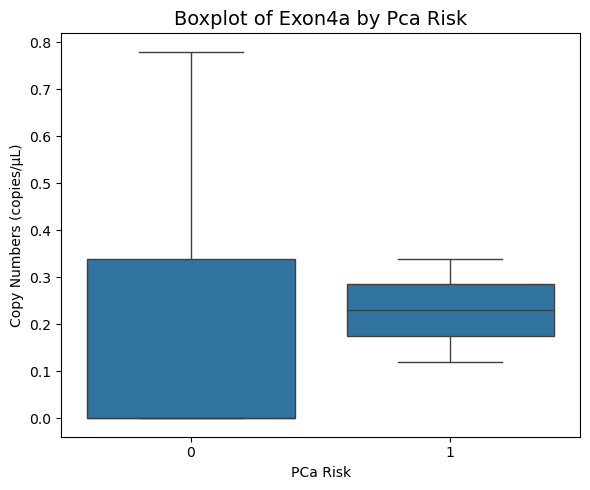

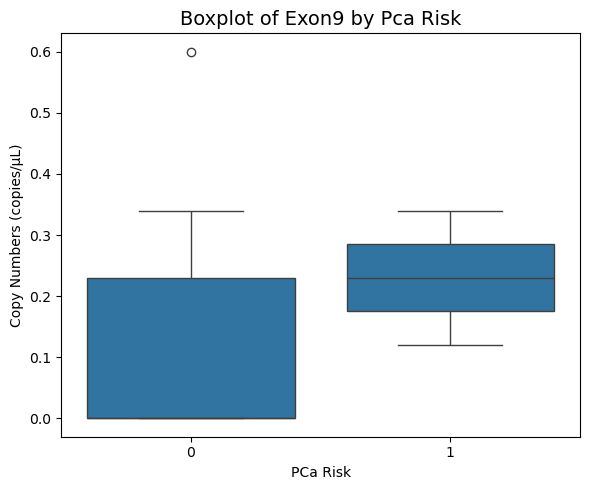

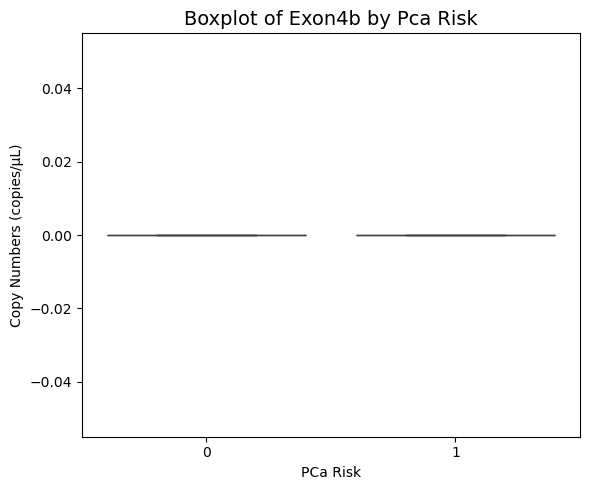

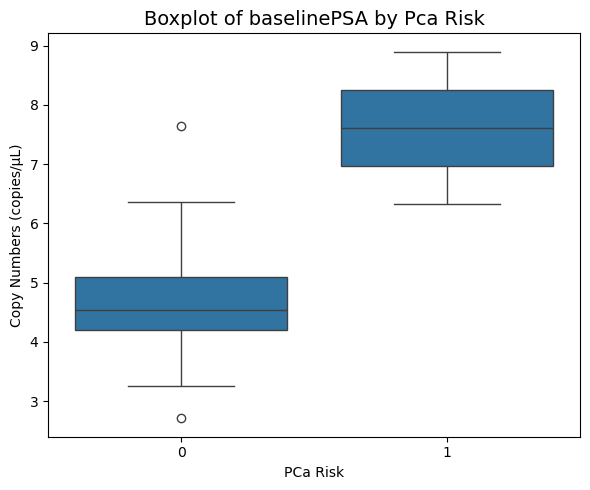

In [660]:

# Define the features
features = ['Exon4a', 'Exon9', 'Exon4b', 'baselinePSA']


# Create separate plots for each feature
for feature in features:
    plt.figure(figsize=(6, 5))

    # Plot boxplot for the current feature
    sns.boxplot(x='GleasonRiskBinary', y=feature, data=data)
    
    # Customize the title and axis labels
    plt.title(f"Boxplot of {feature} by Pca Risk", fontsize=14)
    plt.xlabel("PCa Risk")
    plt.ylabel("Copy Numbers (copies/µL)")
    
    # Display the plot
    plt.tight_layout()
    plt.show()

## Single Logistic Regression

In [661]:
models = [
    ['Exon4a'],            
    ['Exon9'],
    ['baselinePSA']                    
]

for model in models:
    print(f"\nModel: {model}")
    
    X = data[model]
    y = data['GleasonRiskBinary']

    X = sm.add_constant(X)  # Adds a constant term to the predictor
    logit_model = sm.Logit(y, X)

    model_2 = logit_model.fit()
    print(model_2.summary())


Model: ['Exon4a']
Optimization terminated successfully.
         Current function value: 0.389569
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:      GleasonRiskBinary   No. Observations:                   15
Model:                          Logit   Df Residuals:                       13
Method:                           MLE   Df Model:                            1
Date:                Mon, 18 Nov 2024   Pseudo R-squ.:                0.007908
Time:                        21:52:44   Log-Likelihood:                -5.8435
converged:                       True   LL-Null:                       -5.8901
Covariance Type:            nonrobust   LLR p-value:                    0.7602
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -2.0621      1.014     -2.033      0.042      -4.050      -0.075
Exon4a    

## Multiple Logistic Regression

In [662]:
models = [
    ['baselinePSA', 'Exon4a', 'Exon9'], 
    ['baselinePSA', 'Exon4a'],            
    ['baselinePSA', 'Exon9'],
    ['baselinePSA']                    
]

for model in models:
    print(f"\nModel: {model}")
    
    X = data[model]
    y = data['GleasonRiskBinary']

    X = sm.add_constant(X)  # Adds a constant term to the predictor
    logit_model = sm.Logit(y, X)

    model_2 = logit_model.fit()
    print(model_2.summary())


Model: ['baselinePSA', 'Exon4a', 'Exon9']
Optimization terminated successfully.
         Current function value: 0.196235
         Iterations 8
                           Logit Regression Results                           
Dep. Variable:      GleasonRiskBinary   No. Observations:                   15
Model:                          Logit   Df Residuals:                       11
Method:                           MLE   Df Model:                            3
Date:                Mon, 18 Nov 2024   Pseudo R-squ.:                  0.5003
Time:                        21:52:44   Log-Likelihood:                -2.9435
converged:                       True   LL-Null:                       -5.8901
Covariance Type:            nonrobust   LLR p-value:                    0.1169
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const         -11.0641      7.048     -1.570      0.116     -24

## Train Test Split

## @ 0.3 threshold

## @ 50%, 50%

In [663]:

for model in models:
    print(f"\nMetrics for feature set: {model}")
    
    X = data[model]
    y = data['GleasonRiskBinary']

    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.50, random_state=66)

    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('logistic_regression', LogisticRegression())
    ])

    # Fit model
    pipeline.fit(X_train, y_train)

   # Get predicted probabilities
    y_pred_proba_train = pipeline.predict_proba(X_train)[:, 1]  # Probabilities for training set
    y_pred_proba = pipeline.predict_proba(X_test)[:, 1]          # Probabilities for test set

    # Apply threshold of 0.5 to get binary predictions
    y_pred_train = (y_pred_proba_train >= 0.3).astype(int)  # Convert to binary predictions for train set
    y_pred = (y_pred_proba >= 0.3).astype(int) 

    # Calculate metrics for the test set
    accuracy_test = metrics.accuracy_score(y_test, y_pred)
    recall_test = metrics.recall_score(y_test, y_pred)
    conf_matrix_test = confusion_matrix(y_test, y_pred)
    tn_test, fp_test, fn_test, tp_test = conf_matrix_test.ravel()
    specificity_test = tn_test / (tn_test + fp_test)

    # Print metrics for test set
    print("\nTest Set Metrics:")
    print(f"Accuracy: {accuracy_test:.3f}")
    print(f"Recall (Sensitivity): {recall_test:.3f}")
    print(f"Specificity: {specificity_test:.3f}")



Metrics for feature set: ['baselinePSA', 'Exon4a', 'Exon9']

Test Set Metrics:
Accuracy: 0.375
Recall (Sensitivity): 1.000
Specificity: 0.286

Metrics for feature set: ['baselinePSA', 'Exon4a']

Test Set Metrics:
Accuracy: 0.375
Recall (Sensitivity): 1.000
Specificity: 0.286

Metrics for feature set: ['baselinePSA', 'Exon9']

Test Set Metrics:
Accuracy: 0.875
Recall (Sensitivity): 1.000
Specificity: 0.857

Metrics for feature set: ['baselinePSA']

Test Set Metrics:
Accuracy: 1.000
Recall (Sensitivity): 1.000
Specificity: 1.000


## @ Youdens threshold

In [664]:

for model in models:
    print(f"\nMetrics for model: {model}")
    
    X = data[model]
    y = data['GleasonRiskBinary']

    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.5, random_state=66)

    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('logistic_regression', LogisticRegression())
    ])

    # Fit model
    pipeline.fit(X_train, y_train)

    # Get predicted probabilities
    y_pred_proba = pipeline.predict_proba(X_test)[:, 1]  # Probabilities for test set

    # Define thresholds
    thresholds = np.arange(0.0, 1.0, 0.1)
    best_youden_index = -1
    best_threshold = 0.5

    for threshold in thresholds:
        # Convert probabilities to binary predictions
        y_pred = (y_pred_proba >= threshold).astype(int)

        # Calculate confusion matrix
        conf_matrix = confusion_matrix(y_test, y_pred)

        # Check if the confusion matrix is valid for binary classification
        if conf_matrix.shape == (2, 2):
            tn, fp, fn, tp = conf_matrix.ravel()

            # Calculate sensitivity and specificity
            sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0
            specificity = tn / (tn + fp) if (tn + fp) > 0 else 0

            # Calculate Youden's Index
            youden_index = sensitivity + specificity - 1

            # Check if this is the best threshold
            if youden_index > best_youden_index:
                best_youden_index = youden_index
                best_threshold = threshold

    # Apply the best threshold for final predictions
    y_pred_final = (y_pred_proba >= best_threshold).astype(int)

    # Calculate final metrics using the best threshold
    accuracy_test = metrics.accuracy_score(y_test, y_pred_final)
    recall_test = metrics.recall_score(y_test, y_pred_final)
    conf_matrix_test = confusion_matrix(y_test, y_pred_final)

    # Check the shape of the final confusion matrix before unpacking
    if conf_matrix_test.shape == (2, 2):
        tn_test, fp_test, fn_test, tp_test = conf_matrix_test.ravel()
        specificity_test = tn_test / (tn_test + fp_test)

        # Print metrics for test set
        print("\nTest Set Metrics:")
        print(f"Best Threshold: {best_threshold:.2f}")
        print(f"Accuracy: {accuracy_test:.3f}")
        print(f"Recall (Sensitivity): {recall_test:.3f}")
        print(f"Specificity: {specificity_test:.3f}")
    else:
        print("\nTest Set Metrics:")
        print(f"Best Threshold: {best_threshold:.2f}")
        print(f"Accuracy: {accuracy_test:.3f}")
        print(f"Recall (Sensitivity): {recall_test:.3f}")
        print("Specificity: Not applicable (only one class present in predictions)")



Metrics for model: ['baselinePSA', 'Exon4a', 'Exon9']

Test Set Metrics:
Best Threshold: 0.50
Accuracy: 0.500
Recall (Sensitivity): 1.000
Specificity: 0.429

Metrics for model: ['baselinePSA', 'Exon4a']

Test Set Metrics:
Best Threshold: 0.90
Accuracy: 0.625
Recall (Sensitivity): 1.000
Specificity: 0.571

Metrics for model: ['baselinePSA', 'Exon9']

Test Set Metrics:
Best Threshold: 0.30
Accuracy: 0.875
Recall (Sensitivity): 1.000
Specificity: 0.857

Metrics for model: ['baselinePSA']

Test Set Metrics:
Best Threshold: 0.20
Accuracy: 1.000
Recall (Sensitivity): 1.000
Specificity: 1.000


## 2 fold cross validation and AUC


Metrics for feature set: ['baselinePSA', 'Exon4a', 'Exon9']
Fold 1: AUC = 1.000
Fold 2: AUC = 0.667
Overall AUC for model ['baselinePSA', 'Exon4a', 'Exon9']: 0.923


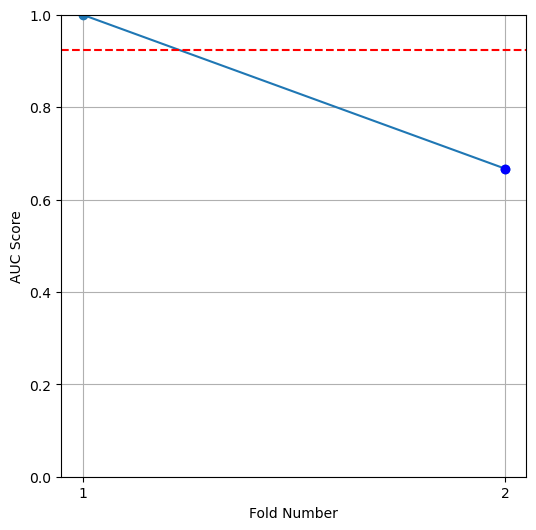


Metrics for feature set: ['baselinePSA', 'Exon4a']
Fold 1: AUC = 1.000
Fold 2: AUC = 0.833
Overall AUC for model ['baselinePSA', 'Exon4a']: 0.962


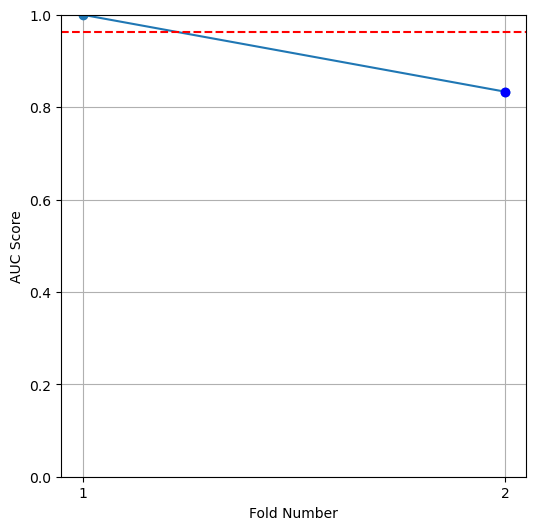


Metrics for feature set: ['baselinePSA', 'Exon9']
Fold 1: AUC = 1.000
Fold 2: AUC = 0.667
Overall AUC for model ['baselinePSA', 'Exon9']: 0.923


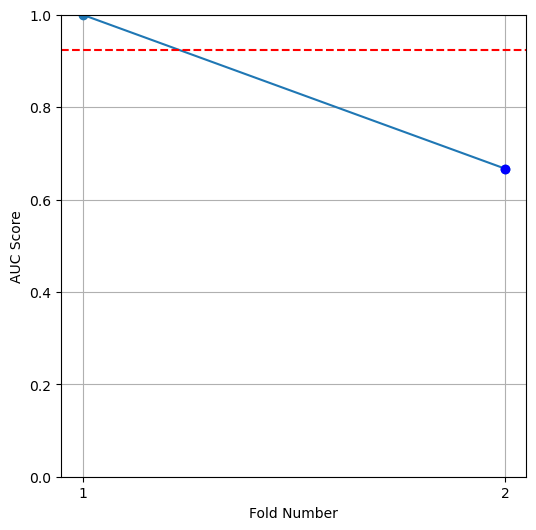


Metrics for feature set: ['baselinePSA']
Fold 1: AUC = 1.000
Fold 2: AUC = 0.667
Overall AUC for model ['baselinePSA']: 0.923


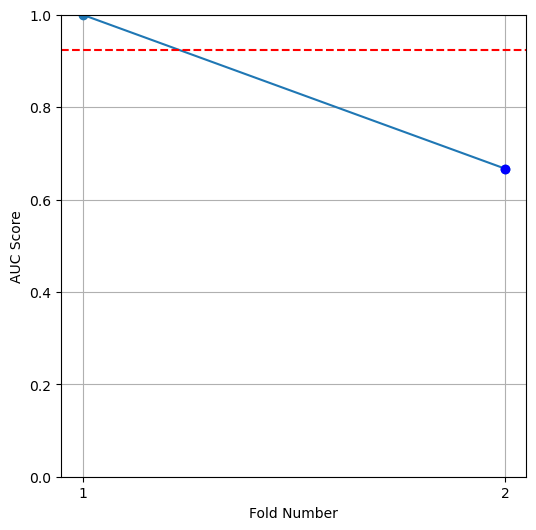

In [665]:
from sklearn import metrics
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
import numpy as np

# Loop through each model and perform 10-fold cross-validation
for model in models:
    print(f"\nMetrics for feature set: {model}")
    
    X = data[model]
    y = data['GleasonRiskBinary']

    # Initialize KFold
    kf = KFold(n_splits=2, shuffle=True, random_state=66)

    fold_auc_scores = []

    # Fit the model on the entire dataset once
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('logistic_regression', LogisticRegression())
    ])

    # Fit the model to the entire dataset
    pipeline.fit(X, y)

    # Get predicted probabilities for the entire dataset
    y_pred_proba = pipeline.predict_proba(X)[:, 1]

    # Calculate AUC for each fold
    for train_index, test_index in kf.split(X):
        # Use the indices to create test labels for AUC calculation
        y_test = y.iloc[test_index]
        y_pred_fold_proba = y_pred_proba[test_index]  # Get probabilities for the test fold

        # Check if both classes are present in the fold
        if len(y_test.unique()) > 1:
            # Calculate AUC for this fold
            fold_auc = metrics.roc_auc_score(y_test, y_pred_fold_proba)
            fold_auc_scores.append(fold_auc)
        else:
            print("Skipping fold due to single class in y_test")

    # Print AUC for each fold
    for i, auc in enumerate(fold_auc_scores):
        print(f"Fold {i + 1}: AUC = {auc:.3f}")

    # Calculate overall AUC using roc_auc_score on the entire predictions
    overall_auc = metrics.roc_auc_score(y, y_pred_proba)
    print(f"Overall AUC for model {model}: {overall_auc:.3f}")

    # Plot AUC for this model with individual segments
    plt.figure(figsize=(6, 6))
    for i in range(len(fold_auc_scores) - 1):
        plt.plot([i + 1, i + 2], [fold_auc_scores[i], fold_auc_scores[i + 1]], marker='o', label=f'Model: {model}' if i == 0 else "")

    # Add last point
    plt.plot([2], [fold_auc_scores[-1]], marker='o', color='b')  

    plt.axhline(y=overall_auc, color='r', linestyle='--', label=f'Overall AUC = {overall_auc:.3f}')

    plt.xlabel('Fold Number')
    plt.ylabel('AUC Score')
    plt.ylim(0, 1)
    plt.xticks(np.arange(1, 3))
    plt.grid()
    plt.show()


## Likelihood Ratio Test

In [666]:

# Custom function for chi-square probability
stats.chisqprob = lambda chisq, df: stats.chi2.sf(chisq, df)

# Define function to perform likelihood ratio test
def likelihood_ratio_test(llmin, llmax):
    lr_stat = 2 * (llmax - llmin)
    p_value = stats.chisqprob(lr_stat, 1)  # llmax has 1 dof more than llmin
    return lr_stat, p_value  # Results of likelihood ratio test

# Response variable
y = data['Statuscode']

# Define model pairs for comparison
model_pairs = [
    (['baselinePSA', 'Exon4a', 'Exon9'], ['baselinePSA', 'Exon4a']),
    (['baselinePSA', 'Exon4a', 'Exon9'], ['baselinePSA', 'Exon9']),
    (['baselinePSA', 'Exon4a'], ['baselinePSA']),
    (['baselinePSA', 'Exon9'], ['baselinePSA'])
]

# Loop through each model pair
for full_features, reduced_features in model_pairs:
    print(f"\nTesting model: {full_features} vs {reduced_features}")

    # Fit the full model
    X_full = data[full_features]
    X_full = sm.add_constant(X_full)  # Adding intercept
    full_model = sm.Logit(y, X_full).fit(disp=0)  # disp=0 to suppress output

    # Fit the reduced model
    X_reduced = data[reduced_features]
    X_reduced = sm.add_constant(X_reduced)  # Adding intercept
    reduced_model = sm.Logit(y, X_reduced).fit(disp=0)  # disp=0 to suppress output

    # Get log-likelihood values
    llmax = full_model.llf  # Log-likelihood of the full model
    llmin = reduced_model.llf  # Log-likelihood of the reduced model

    # Perform the likelihood ratio test
    lr_stat, p_value = likelihood_ratio_test(llmin, llmax)

    # Print results
    print(f"Likelihood Ratio Statistic: {lr_stat:.4f}")
    print(f"P-value: {p_value:.4f}")



Testing model: ['baselinePSA', 'Exon4a', 'Exon9'] vs ['baselinePSA', 'Exon4a']
Likelihood Ratio Statistic: 2.5790
P-value: 0.1083

Testing model: ['baselinePSA', 'Exon4a', 'Exon9'] vs ['baselinePSA', 'Exon9']
Likelihood Ratio Statistic: 6.5142
P-value: 0.0107

Testing model: ['baselinePSA', 'Exon4a'] vs ['baselinePSA']
Likelihood Ratio Statistic: 4.0328
P-value: 0.0446

Testing model: ['baselinePSA', 'Exon9'] vs ['baselinePSA']
Likelihood Ratio Statistic: 0.0975
P-value: 0.7548
